# (19) fit — iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 3
device = f'cuda:{device_idx}'

## Fit one model

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'jac|lin')

cfg_vae['init_scale'] = 1e-2
cfg_vae['seq_len'] = 5

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 600
cfg_tr['batch_size'] = 500
cfg_tr['kl_beta'] = 3.0
cfg_tr['kl_balancer'] = None

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_latents': 512, 'prior_clamp': -4, 'enc_type': 'jac', 'dec_type': 'lin', 'enc_bias': False, 
'dec_bias': False, 'init_dist': 'normal', 'init_scale': 0.01, 'seq_len': 5}

Trainer:
{'batch_size': 500, 'epochs': 600, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 'kl_const_portion': 
0.0, 'lr': 0.002, 'kl_beta': 3.0, 'kl_balancer': None}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  132.1 K   |
|     ———     |    ———     |
|  layers.L_0 |  132.1 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_t-5_z-[512]_k-32_<jac|lin>
mc_b500-ep600-lr(0.002)_beta(3:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_08_30,17:26)

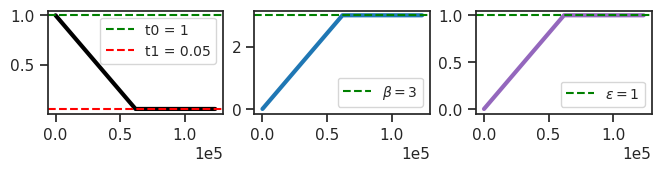

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.input_layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  132.1 K   |
|     ———      |    ———     |
|    fc_dec    |  131.1 K   |
+--------------+------------+

### Fit model

In [7]:
tr.train(fit_name = f"dMSE_*LogGain_bal-{tr.cfg.kl_balancer}_{tr.cfg.name()}")

epoch # 600, avg loss: 113.720847: 100%|███████████████████████████████████████████████████████| 600/600 [1:47:09<00:00, 10.72s/it]


In [8]:
print(tr.model.input_layer)

PoissonLayer(dim=512, input_dim=16, temp=0.05, n_exp=84, beta=3, eps=1)

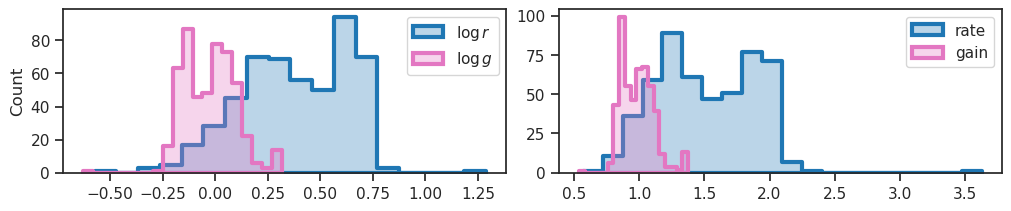

In [51]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
log_gain = tonp(tr.model.input_layer.log_gain).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)
sns.histplot(log_gain, color='C6', element='step', label=r'$\log g$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(np.exp(log_gain), color='C6', element='step', label='gain', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

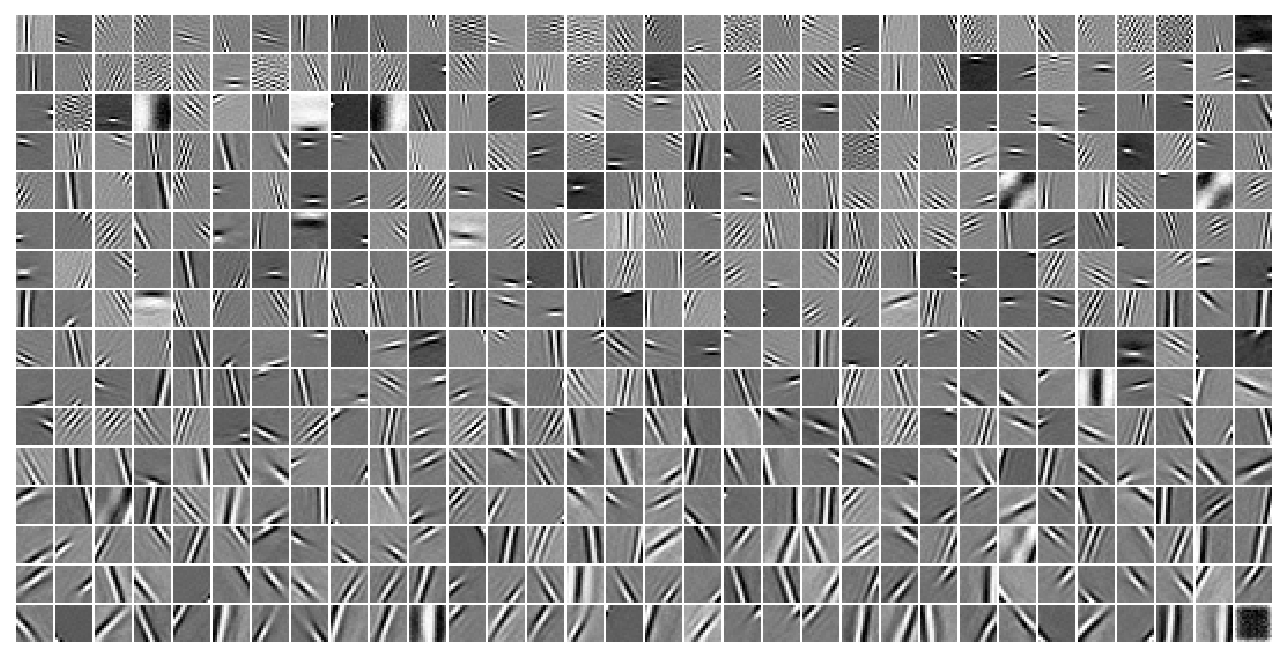

In [52]:
tr.model.show('dec', order=np.argsort(log_rate));

In [53]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'].copy()
loss = {
    k: np.mean(v, 0) for k, v in
    loss.items() if k != 'kl_diag'
}
print(loss)

{
    'kl': array([14.842936 , 14.377552 , 11.916402 ,  9.0718155,  7.1894464],
      dtype=float32),
    'recon': array([163.0118  , 122.21363 ,  93.454765,  76.32846 ,  66.78856 ],
      dtype=float32),
    'nelbo': array([177.85577 , 136.59134 , 105.37067 ,  85.400276,  73.97833 ],
      dtype=float32)
}

### Analysis

In [54]:
results = tr.analysis(2000, verbose=True)

100%|█████████████████████████████████| 52/52 [07:26<00:00,  8.59s/it]


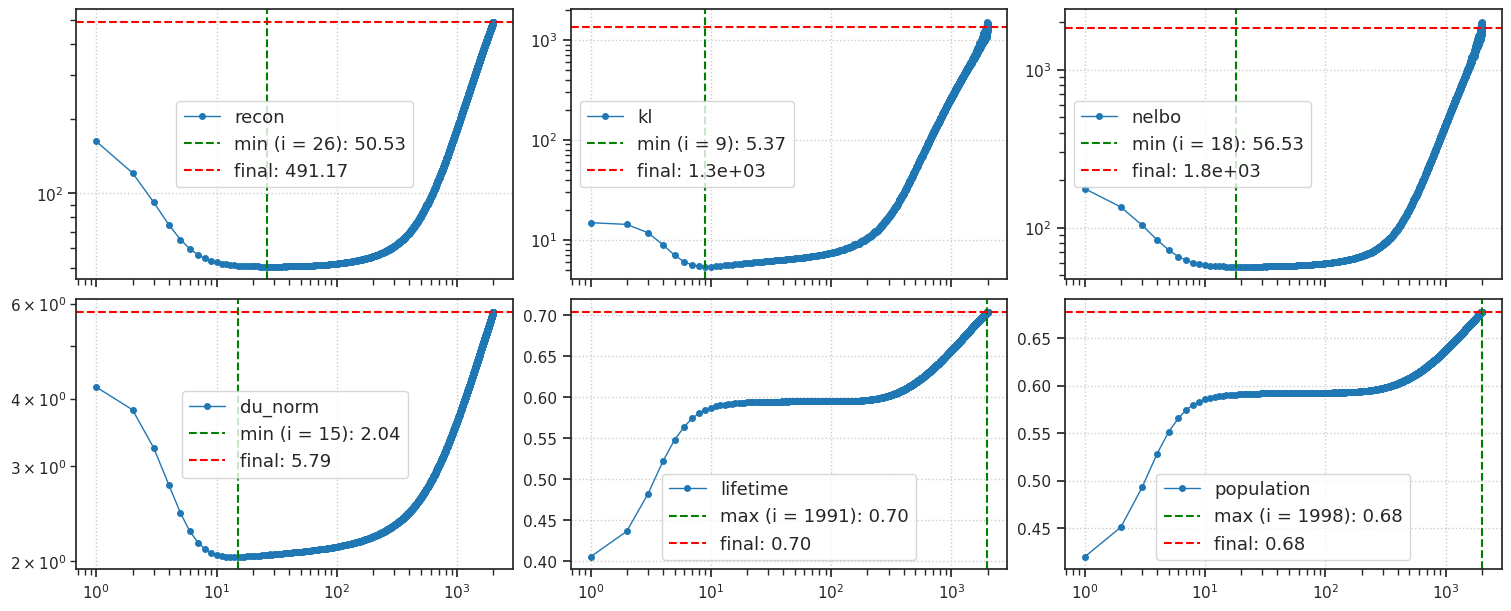

In [55]:
from figures.analysis import plot_convergence
plot_convergence(results)

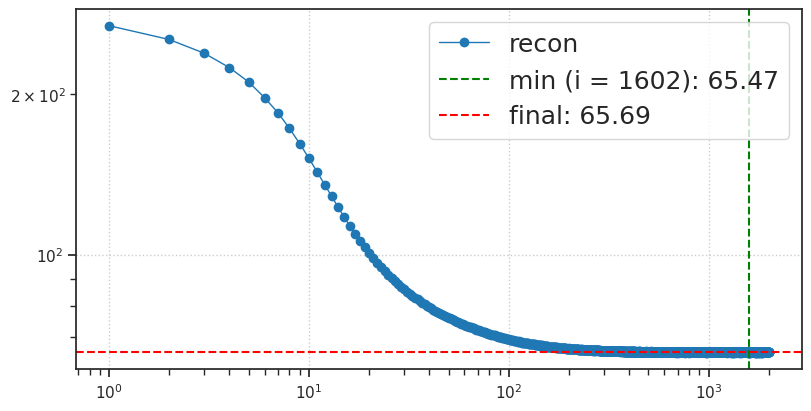

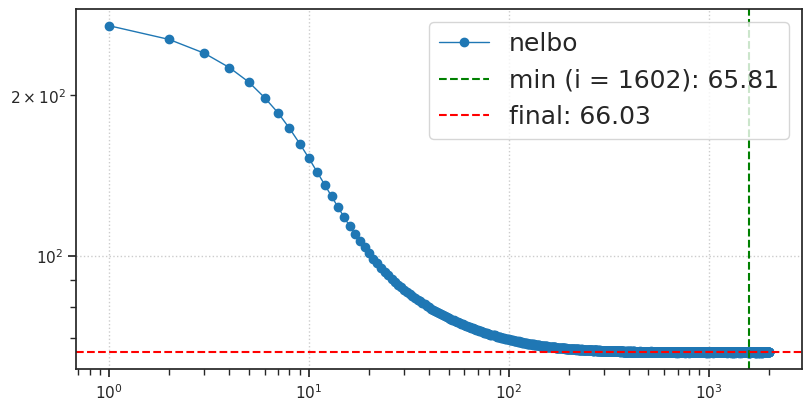

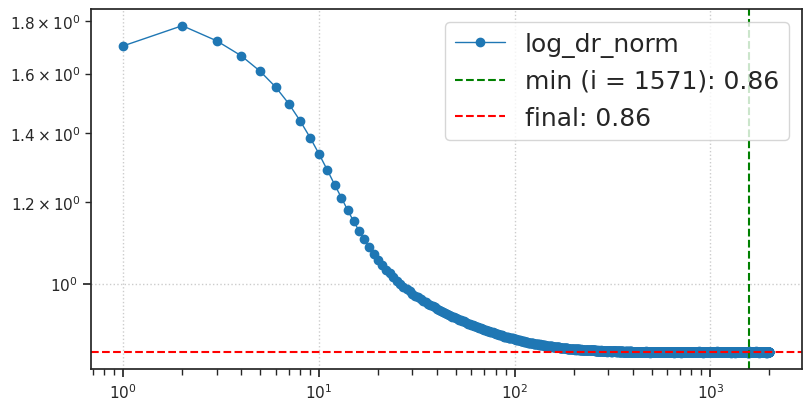

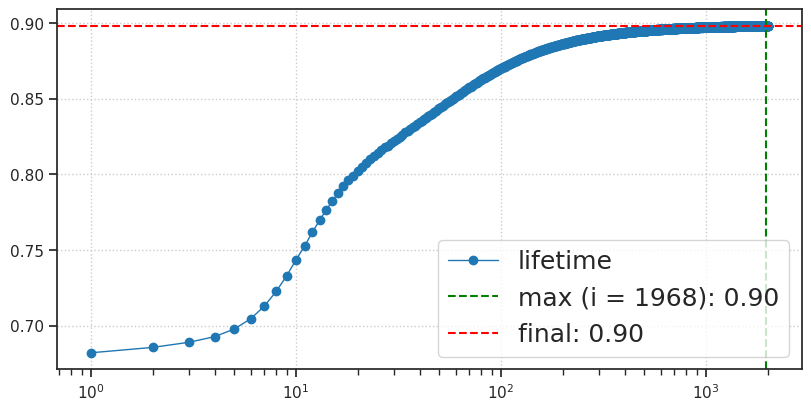

In [11]:
## Was: linear + t_stop = 0.05

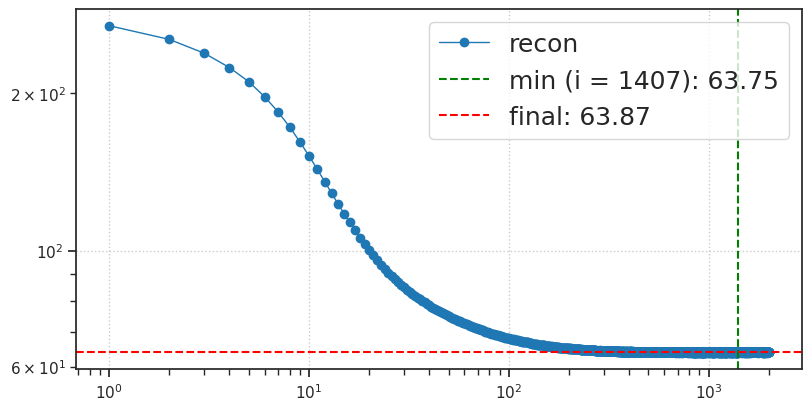

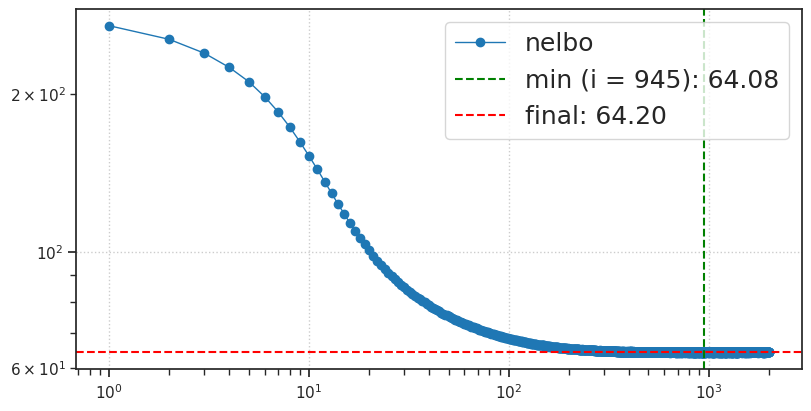

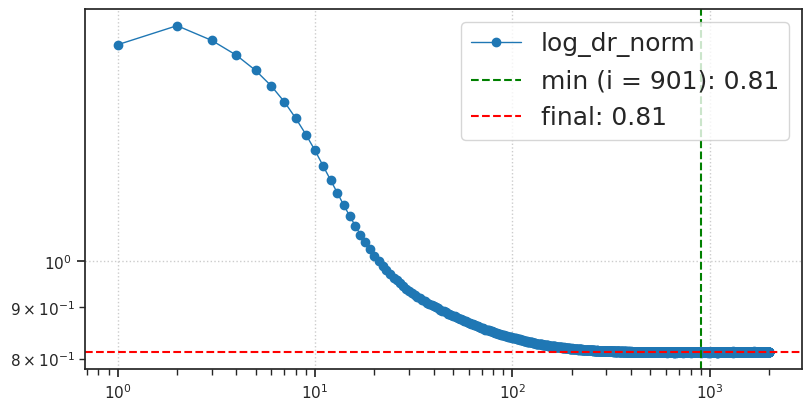

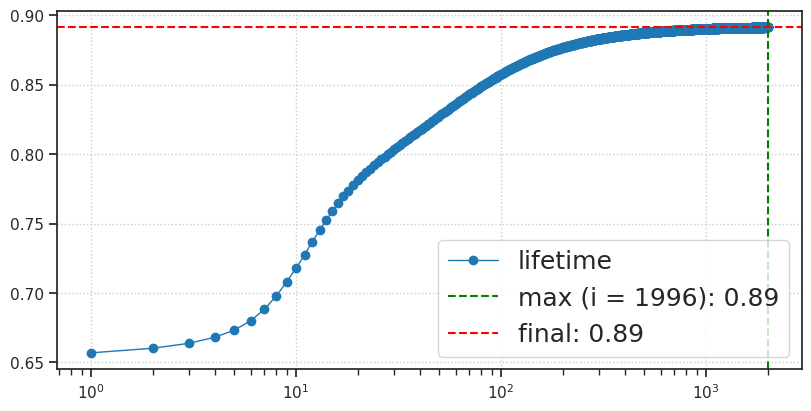

In [13]:
## was w/ gate

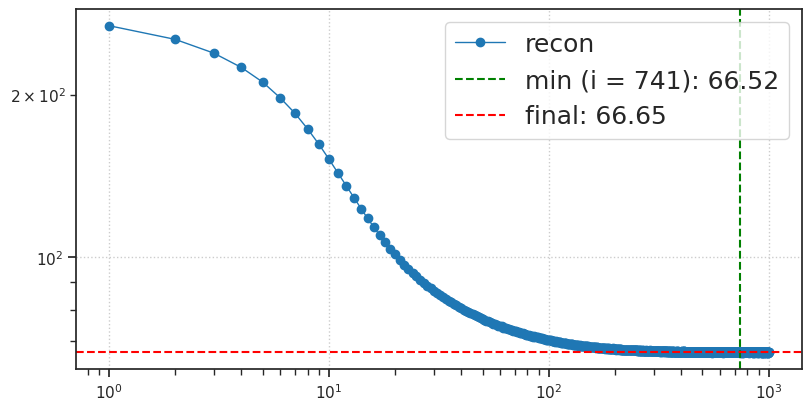

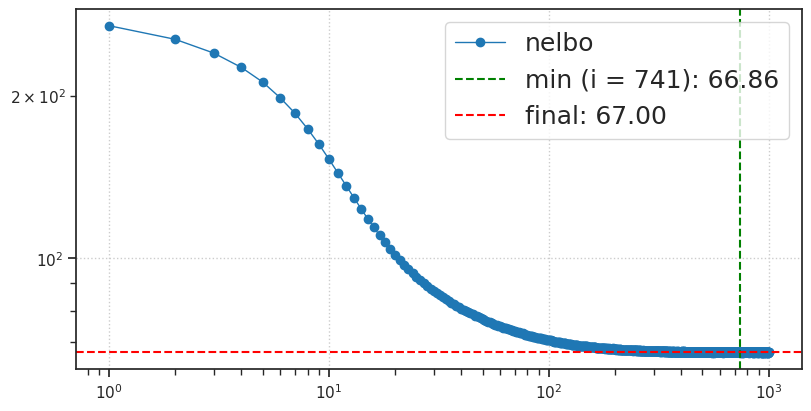

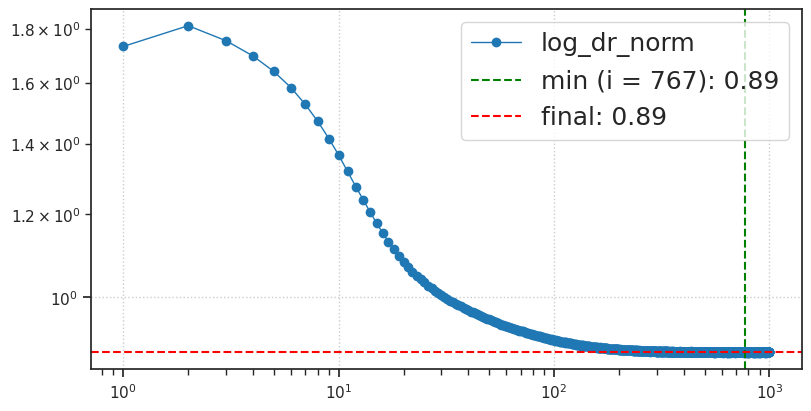

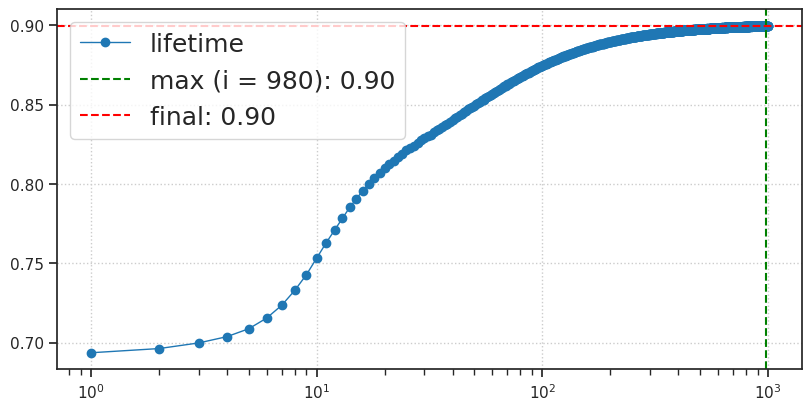

In [13]:
## Was linear

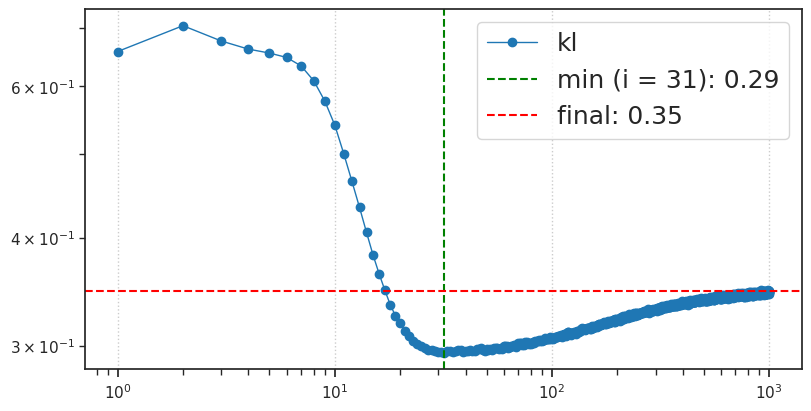

In [15]:
fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['kl'])), results['kl'], lw=1, marker='o', label='kl')

min_i = np.argmin(results['kl'])
last = results['kl'][-1]
ax.axvline(min_i + 1, color='g', ls='--', label=f"min (i = {min_i}): {results['kl'][min_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='log')
ax.legend(fontsize=18)
ax.grid()
plt.show()

In [16]:
# data, loss, ect = tr.validate(full_data=True)

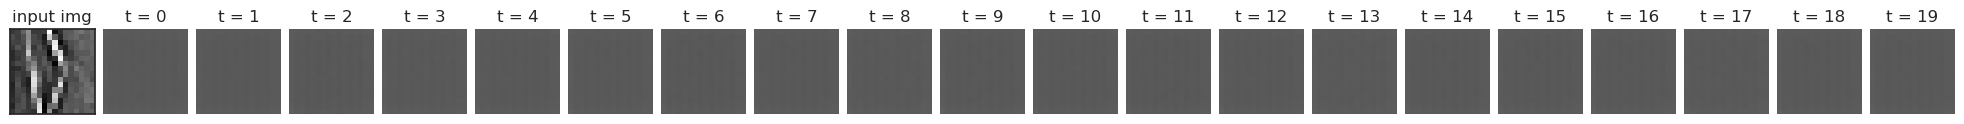

In [15]:
ncols = 1 + cfg_vae['seq_len']
fig, axes = create_figure(1, ncols, (0.93 * ncols, 1.3), 'all', 'all')

ax = axes[0]
x2p = data['x'][124].reshape(16, 16)
kws = dict(vmin=x2p.min(), vmax=x2p.max(), cmap='Greys_r')
ax.imshow(x2p, **kws)
ax.set_title('input img')

for t in range(cfg_vae['seq_len']):
    ax = axes[t + 1]
    ax.imshow(data['y'][124, t].reshape(16, 16), **kws)
    ax.set_title(f"t = {t}")
remove_ticks(axes[1:])
ax_square(axes);

In [54]:
x = next(iter(tr.dl_vld))[0]

output = tr.model.xtract_ftr(x, seq=range(2000))
output = output.stack()

list(output)

['recon', 'dist', 'spks', 'ff', 'fb', 'loss_kl', 'loss_recon']

In [56]:
output['spks'].shape

torch.Size([500, 2000, 512])

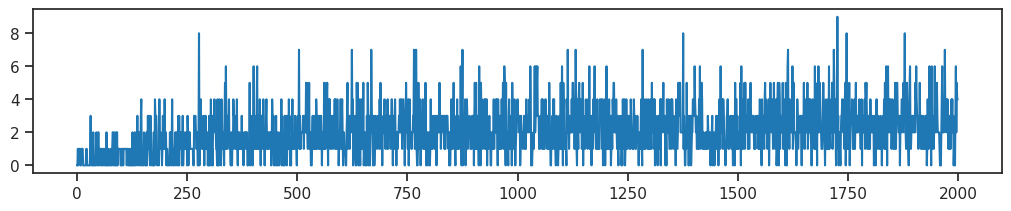

In [77]:
sample_i, neuron_i = 123, 101
x2p = tonp(output['spks'][sample_i, :, neuron_i])

fig, ax = create_figure(1, 1, (10, 2))
ax.plot(x2p)
plt.show()

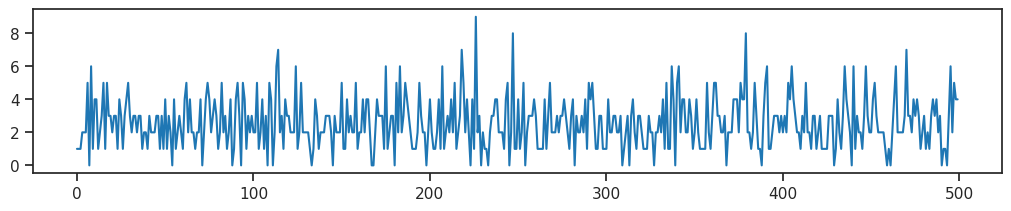

In [79]:
fig, ax = create_figure(1, 1, (10, 2))
ax.plot(x2p[1500:])
plt.show()

In [17]:
self = tr.model.input_layer
self.reset_state(32)

In [18]:
dist, z, pred = self.generate(0.0)
pred.shape

torch.Size([32, 1, 16, 16])

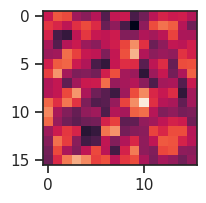

In [20]:
plt.imshow(tonp(pred[13, 0]));

In [42]:
output = tr.model.xtract_ftr(pred, seq=range(2000))
output = output.stack()
list(output)

['recon', 'dist', 'spks', 'ff', 'fb', 'loss_kl', 'loss_recon']

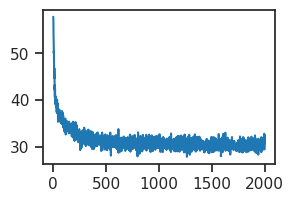

In [43]:
x2p = tonp(output['loss_recon'].mean(0))
plt.plot(x2p);

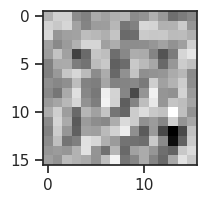

In [44]:
x2p = tonp(output['recon'][9, -1, 0])
plt.imshow(x2p, cmap='Greys')